In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install underthesea
!pip install gensim
# !pip install fasttext
!pip install tensorflow_text

In [3]:
import tensorflow as tf
import random
from keras import backend as K
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text

import pickle
import gzip
import keras
# import fasttext
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from underthesea import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
 
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Add
from keras.layers import Attention
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.layers.wrappers import Bidirectional
from keras.layers import Dense, Lambda, dot, Activation, concatenate, Embedding, LSTM, Dropout, Flatten, BatchNormalization, Input
from keras.initializers import Constant
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# LOAD DATA

**Load data**

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/NLP/train5.csv"

In [ ]:
names = ["questions", "answers"]
dataset = pd.read_csv(train_path, names=names)
dataset.head(5)

**Load các từ viết tắt**

In [6]:
acronyms_path = "./static/Acronyms/Acronyms.csv"


In [7]:
names = ["keys", "meanings"]
acronyms = pd.read_csv(acronyms_path, names=names)
acronyms.head(5)

,keys,meanings
0,DHCNN,Đại học Công nghiệp
1,DHCN,Đại học Công nghiệp
2,ĐHCN,Đại học Công nghiệp
3,IUH,Đại học Công nghiệp
4,TP,Thành phố


# PREPROCESSING DATA

**TÁCH TỪ**

In [ ]:
original_stopwords = ["thưa"]

def create_stopwords(path):
  with open(path, encoding="utf-8") as words:
    return [w[:len(w) - 1] for w in words] + original_stopwords

stopwords = create_stopwords('/content/drive/MyDrive/Colab Notebooks/NLP/vietnamese-stopwords.txt')

In [9]:
#Chuẩn hóa từ viết tắt
def acronyms_processing(sentence):
  new_sentence = []
  keys = [key.lower() for key in acronyms['keys'].values.tolist()]
  meanings = [meaning.lower() for meaning in acronyms['meanings'].values.tolist()]
  for word in sentence:
    if word in keys:
      temp = [word for word in word_tokenize(meanings[keys.index(word)])]
      for i in temp:
        new_sentence.append(i)
    else:
      new_sentence.append(word)
  return new_sentence

In [11]:
#Tách từ
def word_processing_question(sentence):
  sentence = [word for word in word_tokenize(sentence.lower())]
  sentence = acronyms_processing(sentence)
  sentence = [word for word in sentence if word ]
  return [word for word in sentence if word != ""]
def word_processing_answer(sentence):
  sentence = [word for word in word_tokenize(sentence.lower())]
  sentence = acronyms_processing(sentence)
  return [word for word in sentence if word != ""]
# input_sentence_questions = [word_processing_question(str(sentence)) for sentence in dataset["questions"].values.tolist()]
# input_sentence_answers = [word_processing_answer(str(sentence)) for sentence in dataset["answers"].values.tolist()]

In [ ]:
print(input_sentence_questions[221])
print(input_sentence_answers[221])

**Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_sentence_questions, input_sentence_answers, test_size=0.2, random_state=42)

In [ ]:
X_test = [" ".join(X_test[i]) for i in range(len(X_test))]
y_test = [" ".join(y_test[i]) for i in range(len(y_test))]

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

In [ ]:
X_test[-1]

**THÊM KÍ TỰ BẮT ĐẦU VÀ KẾT THÚC**

In [12]:
def preprocess_sentence(sentence):
  new_sentence=['<start>']
  for word in sentence:
    new_sentence.append(word)
  new_sentence.append('<end>')
  return new_sentence
# X_train=[preprocess_sentence(sentence) for sentence in X_train]
# y_train=[preprocess_sentence(sentence) for sentence in y_train]

In [ ]:
print(X_train[0])
print(y_train[0])

**TẠO TỪ ĐIỂN**

In [ ]:
#Tạo từ điển
word2id_question = dict() #dict gồm (từ: thứ tự)
word2id_answer = dict()
max_words_questions = 0 #Câu có nhiều từ nhất trong newvocal
max_words_answers = 0
word_size_question=0 #Độ dài từ điển
word_size_answer=0
 
for sentence in X_train:
    for word in sentence:
        if word not in word2id_question:
            word_size_question+=1
            word2id_question[word] = word_size_question
    if len(sentence) > max_words_questions:
        max_words_questions = len(sentence)
for sentence in y_train:
    for word in sentence:
        if word not in word2id_answer:
            word_size_answer+=1
            word2id_answer[word] = word_size_answer
    if len(sentence) > max_words_answers:
        max_words_answers = len(sentence)
    
id2word_question = {v: k for k, v in word2id_question.items()} #dict gồm (thứ tự: từ)
id2word_answer = {v: k for k, v in word2id_answer.items()}
word2id_answer['[Pad]']=0  #Thêm vào dict word2id 1 phần tử có key là [Pad] và value là 0 (Vì danh sách có vị trí lúc nãy bắt đầu từ 1)
id2word_answer[0]='[Pad]'  #Thêm vào dict id2word 1 phần tử có key là 0 và value là [Pad] (Vì danh sách có vị trí lúc nãy bắt đầu từ 1)
word2id_question['[Pad]']=0
id2word_question[0]='[Pad]'

In [ ]:
#Save tu dien
import pickle
def save_word2id(obj, name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_word2id(name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_id2word(obj, name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_id2word(name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_word2id(word2id_question, 'word2id_question')
save_word2id(word2id_answer, 'word2id_answer')
save_id2word(id2word_question, 'id2word_question')
save_id2word(id2word_answer, 'id2word_answer')

In [ ]:
word2id_question=load_word2id('word2id_question')
word2id_answer=load_word2id('word2id_answer')
id2word_question=load_id2word('id2word_question')
id2word_answer=load_id2word('id2word_answer')

In [ ]:
print("Max length question: %d" % (max_words_questions))
print("Vocab size question: %d" % len(word2id_question))
print("Max length answer: %d" % (max_words_answers))
print("Vocab size answer: %d" % len(word2id_answer))

**DATA GENERATOR**

In [13]:
def padding(s, max_words):
  s_s = s.copy();
  # s_s=' '.join(s_s)
  # s_s+=" [Pad]"*(max_words-len(s_s))
  for i in range(max_words-len(s)):
    s_s.append("[Pad]")
  return s_s
def encode_question(s):
  return [word2id_question[i] for i in s]
def encode_answer(s):
  return [word2id_answer[i] for i in s]
def decode_question(s):
  return [id2word_question[i] for i in s]
def decode_answer(s):
  return [id2word_answer[i] for i in s]

In [ ]:
X_train =  np.array([encode_question(padding(i, max_words_questions)) for i in X_train])
y_train =  np.array([encode_answer(padding(i, max_words_answers)) for i in y_train])
print(X_train.shape)
print(y_train.shape)

In [ ]:
print(X_train[1500])
print(y_train[1500])

# EMBEDDING

**TẠO MODEL EMBEDDING**

In [ ]:
modelcbow_question = Word2Vec(size=300, window=23, min_count=3, workers=4, sg=0)
modelcbow_question.build_vocab(input_sentence_questions)
# words = list(modelcbow_question.wv.vocab)
# print(words)
modelcbow_question.train(input_sentence_questions, total_examples = modelcbow_question.corpus_count, epochs=300)
modelcbow_question.save('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/modelcbow_question.bin')

In [ ]:
modelcbow_question = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/modelcbow_question.bin')

In [ ]:
testcbow = modelcbow_question.predict_output_word(['sinh viên','hồ sơ', 'nộp'], topn=1)
print(testcbow)
testcbow = modelcbow_question.predict_output_word(['quy chế','đào tạo', 'hệ thống'], topn=1)
print(testcbow)
testcbow = modelcbow_question.predict_output_word(['trường hợp','chuyển trường','thuộc'], topn=1)
print(testcbow)
testcbow = modelcbow_question.predict_output_word(['học phí','online','đóng'], topn=1)
print(testcbow)

In [ ]:
modelcbow_answer = Word2Vec(size=300, window=17, min_count=3, workers=4, sg=0)
modelcbow_answer.build_vocab(input_sentence_answers)
modelcbow_answer.train(input_sentence_answers, total_examples=modelcbow_question.corpus_count, epochs=300)
modelcbow_answer.save('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/modelcbow_answer.bin')

In [ ]:
modelcbow_answer = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/modelcbow_answer.bin')

In [ ]:
testcbow = modelcbow_answer.predict_output_word(['hệ','đại học', 'liên thông', '1.5'], topn=1)
print(testcbow)
testcbow = modelcbow_answer.predict_output_word(['học phần','chứa đựng','những'], topn=1)
print(testcbow)
testcbow = modelcbow_answer.predict_output_word(['chỉ', 'khi','đã','hoàn thành', 'đầy đủ','thủ tục'], topn=1)
print(testcbow)
testcbow = modelcbow_answer.predict_output_word(['quy chế','đào tạo', 'trường', 'đại học', 'công nghiệp', 'thành phố', 'chí minh', 'hồ'], topn=1)
print(testcbow)

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = modelcbow_question[modelcbow_question.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(modelcbow_question.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
import io

out_v = io.open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/q_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/q_meta.tsv', 'w', encoding='utf-8')

words = list(modelcbow_question.wv.vocab)
vectors = X
for i in range(len(words)):
  out_m.write(words[i] + "\n")
  out_v.write('\t'.join([str(x) for x in vectors[i]]) + "\n")

out_v.close()
out_m.close()

**TẠO MA TRẬN EMBEDDING TỪ MÔ HÌNH CBOW**

In [ ]:
# embedding matrix
print('preparing embedding matrix...')
 
MAX_NB_WORDS = 100000
words_not_found = []
embedding_dim = 300 # The dimension of word embeddings
nb_words_question = min(MAX_NB_WORDS, len(word2id_question))
nb_words_answer = min(MAX_NB_WORDS, len(word2id_answer))
 
# Với mỗi từ trong câu, lưu lại word vector phục vụ để huấn luyện mô hình
question_embedding_matrix = np.zeros((nb_words_question, embedding_dim))
answer_embedding_matrix = np.zeros((nb_words_answer, embedding_dim))
for word, i in word2id_question.items():
  try:
    if i >= nb_words_question:
      continue
    question_embedding_vector = modelcbow_question[word]
    if (question_embedding_vector is not None) and len(question_embedding_vector) > 0:
      question_embedding_matrix[i] = question_embedding_vector
    else:
      words_not_found.append(word)
  except:
    words_not_found.append(word)
 
for word, i in word2id_answer.items():
  try:
    if i >= nb_words_answer:
      continue
    answer_embedding_vector = modelcbow_answer[word]
    if (answer_embedding_vector is not None) and len(answer_embedding_vector) > 0:
      answer_embedding_matrix[i] = answer_embedding_vector
    else:
      words_not_found.append(word)
  except:
    words_not_found.append(word)
print('number of null question word embeddings: %d' % np.sum(np.sum(question_embedding_matrix, axis=1) == 0))
print('number of null answer word embeddings: %d' % np.sum(np.sum(answer_embedding_matrix, axis=1) == 0))

In [ ]:
def save_question_embedding_matrix(obj, name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_question_embedding_matrix(name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def save_answer_embedding_matrix(obj, name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_answer_embedding_matrix(name):
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Transformer_Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_question_embedding_matrix(question_embedding_matrix, 'question_embedding_matrix')
save_answer_embedding_matrix(answer_embedding_matrix, 'answer_embedding_matrix')

In [ ]:
question_embedding_matrix=load_question_embedding_matrix('question_embedding_matrix')
answer_embedding_matrix=load_answer_embedding_matrix('answer_embedding_matrix')

# MODEL

**MODEL**

In [41]:
#Save tu dien
import pickle
def save_word2id(obj, name):
    with open('./Trained/Vocab/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_word2id(name):
    with open('./Trained/Vocab/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_id2word(obj, name):
    with open('./Trained/Vocab/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_id2word(name):
    with open('./Trained/Vocab/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

max_words_answers = 247
max_words_questions = 58
word2id_question=load_word2id('word2id_question')
word2id_answer=load_word2id('word2id_answer')
id2word_question=load_id2word('id2word_question')
id2word_answer=load_id2word('id2word_answer')
print("Max length question: %d" % (max_words_questions))
print("Vocab size question: %d" % len(word2id_question))
print("Max length answer: %d" % (max_words_answers))
print("Vocab size answer: %d" % len(word2id_answer))


Max length question: 58
Vocab size question: 1358
Max length answer: 247
Vocab size answer: 970


In [ ]:
X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_trainn.shape)
print(X_val.shape)

In [16]:
# buffer_size = len(X_trainn)
# buffer_vsize = len(X_val)

batch_size=50

# steps_per_epoch = len(X_trainn)//batch_size
# vsteps_per_epoch = len(X_val)//batch_size

units = 1024
embedding_dim=300

# vocab_inp_size = len(word2id_question)
# vocab_tar_size = len(word2id_answer)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_trainn, y_trainn)).shuffle(buffer_size)
# train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(buffer_vsize)
# val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
for example_input_batch, example_target_batch in train_dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [19]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

In [20]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

In [23]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, embeddings_initializer=Constant(question_embedding_matrix))
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=300, num_heads=5,
                         dff=2048, input_vocab_size=len(word2id_question),
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, embeddings_initializer=Constant(answer_embedding_matrix))
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=300, num_heads=5,
                         dff=2048, target_vocab_size=len(word2id_answer),
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

In [28]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=300, num_heads=5, dff=2048,
    input_vocab_size=len(word2id_question), target_vocab_size=len(word2id_answer),
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [29]:
num_layers = 4
d_model = 300
dff = 512
num_heads = 10
dropout_rate = 0.1

In [ ]:
num_layers = 4
d_model = 300
dff = 512
num_heads = 5
dropout_rate = 0.1

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

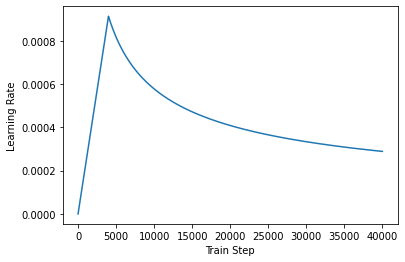

In [32]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [34]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='train_loss')
val_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [36]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(word2id_question),
    target_vocab_size=len(word2id_answer),
    pe_input=len(word2id_question),
    pe_target=len(word2id_answer),
    rate=dropout_rate)

In [37]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
checkpoint_path = "./Trained/Model_Transformer_4"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [ ]:
EPOCHS = 20
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
test_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=test_step_signature)
def test_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  predictions, _ = transformer(inp, tar_inp,
                              True,
                              enc_padding_mask,
                              combined_mask,
                              dec_padding_mask)
  loss = loss_function(tar_real, predictions)

  val_loss(loss)
  val_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
EPOCHS = 3

In [ ]:
tlosses = []
vlosses = []
taccuracys = []
vaccuracys = []
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    if batch % 40 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')


  for (batch, (inp, tar)) in enumerate(val_dataset):
    test_step(inp, tar)
    if batch % 10 == 0:
      vlosses.append(val_loss.result())
      vaccuracys.append(val_accuracy.result())
      print(f'Epoch {epoch + 1} Batch {batch} Val_loss {val_loss.result():.4f} Val_accuracy {val_accuracy.result():.4f}')

  tlosses.append(train_loss.result())
  taccuracys.append(train_accuracy.result())
  vlosses.append(val_loss.result())
  vaccuracys.append(val_accuracy.result())
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Val_accuracy {val_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tlosses)
plt.plot(vlosses)
plt.title('LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()


plt.plot(taccuracys)
plt.plot(vaccuracys)
plt.title('ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

**TEST MODEL**

In [43]:
max_words_questions


58

In [42]:
def evaluate(input_sentence, max_length=len(word2id_answer)):
  # inp sentence is portuguese, hence adding the start and end token

  sentence = word_processing_question(input_sentence)
  sentence = preprocess_sentence(sentence)
  inputs = padding(sentence, max_words_questions)
  inputs = [[word2id_question[i] for i in inputs]]

  inputs = tf.convert_to_tensor(inputs)

  encoder_input = inputs

  result = ''

  output = tf.cast(tf.expand_dims([word2id_answer['<start>']], 0), dtype=tf.int64)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)


    # return the result if the predicted_id is equal to the end token
    id = tf.reshape(predicted_id,()).numpy()

    if id2word_answer[id] == '<end>':
      break

    result += id2word_answer[id] + ' '
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return result.strip(), input_sentence, attention_weights

In [44]:
def answering(sentence):
  result, sentence, attention_weights = evaluate(sentence)
  print('-')
  print('Input: %s' % (sentence))
  print('Predicted the answer: {}'.format(result))

In [45]:
answering('điểm rèn luyện của sinh viên được tính thế nào?')

-
Input: điểm rèn luyện của sinh viên được tính thế nào?
Predicted the answer: điểm rèn luyện của năm học là trung bình cộng của điểm rèn luyện các học kỳ của năm đó .


In [ ]:
acc_eval_4_gram = []
for i in range(len(X_test)):
  try:
    result, sentence, attention_weights = evaluate(X_test[i])
    reference = [y_test[i].split()]
    candidate = result.split()
    smoothie = SmoothingFunction().method4
    acc_eval_4_gram.append(sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))
  except:
    None

In [ ]:
print('Độ chính xác của mô hình đạt: {:.4f}'.format(sum(acc_eval_4_gram)/len(acc_eval_4_gram)))

In [ ]:
print('Độ chính xác của mô hình đạt: {:.4f}'.format(sum(acc_eval_4_gram)/len(acc_eval_4_gram)))

In [ ]:
for i in range(0,5):
  try:
    d = random.randint(0, len(X_test))
    answering(X_test[d])
    print('True sentence is: {}'.format(y_test[d]))
    print("-")
  except:
    None

In [46]:
answering('Thầy cô có thể giải thích cho em về điều kiện để mở lớp học phần được không ạ?')

-
Input: Thầy cô có thể giải thích cho em về điều kiện để mở lớp học phần được không ạ?
Predicted the answer: số lượng sinh viên đăng ký thấp hơn chuẩn tối thiểu thì lớp học sẽ không được tổ chức và sinh viên phải đăng ký chuyển sang học phần khác có lớp . số lượng sinh viên tối thiểu để xem xét mở lớp học phần trong học kỳ đối với các học phần lý thuyết là : - ít nhất 50 sinh viên cho các học phần cơ bản , cơ sở của các nhóm ngành lớn và 30 sinh viên đăng ký cho các học phần khác ; - trong trường hợp các học phần chuyên ngành , trường sẽ xem xét để mở các lớp có sĩ số chưa đủ điều kiện mở lớp ; - số lượng sinh viên để xem xét mở lớp học phần trong học kỳ đối với các học phần thí nghiệm , thực hành được xác định bởi đơn vị đào tạo , tối thiểu 20 sinh viên .


In [47]:
answering('Những điều nào sinh viên cần chú ý nếu sinh viên không tham gia kỳ thi giữa kì của các môn học phần đang học vậy ạ?')

-
Input: Những điều nào sinh viên cần chú ý nếu sinh viên không tham gia kỳ thi giữa kì của các môn học phần đang học vậy ạ?
Predicted the answer: sinh viên nghỉ quá 20 phần trăm số tiết thì không được dự thi cuối kì .


In [48]:
answering('hỏi cái, sinh viên muốn đi học lại sau khi tạm hoãn thì làm thế nào?')

-
Input: hỏi cái, sinh viên muốn đi học lại sau khi tạm hoãn thì làm thế nào?
Predicted the answer: chỉ khi sinh viên đã hoàn thành đầy đủ các thủ tục nhập học , nộp học phí và các khoản thu khác ( nếu có ) theo quy định của nhà trường , mới được công nhận là sinh viên chính thức của trường và được cấp thẻ sinh viên .


In [49]:
answering('em đang học lớp 12 và có nhu cầu ứng tuyển vào trường DHCN nhưng em chưa rõ quy định về tín chỉ, vậy cho em hỏi quy chế đào tạo theo hệ thống tín chỉ là cái gì vậy ạ?')

-
Input: em đang học lớp 12 và có nhu cầu ứng tuyển vào trường DHCN nhưng em chưa rõ quy định về tín chỉ, vậy cho em hỏi quy chế đào tạo theo hệ thống tín chỉ là cái gì vậy ạ?
Predicted the answer: - trên cơ sở chương trình đào tạo , quy chế đào tạo theo hệ thống tín chỉ tạo điều kiện tối đa cho sinh viên phát huy tích cực , chủ động , sáng tạo trong việc sắp xếp lịch học , đăng ký khối lượng kiến thức sẽ tích lũy trong từng học kỳ , tích lũy các học phần , kể cả sắp xếp thời gian học ở trường , thời gian tốt nghiệp , ra trường . - quy chế này cũng tạo điều kiện để sinh viên tích cực chủ động thích ứng với quy trình đào tạo để đạt được những kết quả tốt nhất trong học tập , rèn luyện .


In [50]:
answering('Mục đích của việc thi thpt là gì?')

-
Input: Mục đích của việc thi thpt là gì?
Predicted the answer: thi trung học phổ thông quốc gia nhằm mục đích : ( i ) dùng kết quả thi để xét công nhận tốt nghiệp trung học phổ thông ; ( ii ) cung cấp thêm thông tin để đánh giá chất lượng giáo dục phổ thông ; ( iii ) cung cấp dữ liệu làm căn cứ để tuyển sinh đại học , cao đẳng .


# END